# Create test dataframe

In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory

debug = True
# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'BTCUSDT': ['1h', '5m'], 'ETHUSDT': ['1h', '5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs
# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_apis[exchange] = DataFactory.factory(exchange, **configs)
# Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_api in exchange_apis.items():
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, new_data_flag = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if new_data_flag:
                indicators = list()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['SUP_RES']
                for indicator in indicator_list:
                    ind_factory = IndicatorFactory.factory(indicator, configs)
                    if ind_factory:
                        indicators.append(ind_factory)
                # Write indicators to dataframe, update dataframe dict
                dfs, df = exchange_api.add_indicator_data(dfs, df, indicators, ticker, timeframe, configs)
                # Get signals
                if timeframe == work_timeframe:
                    fs = FindSignal(configs)
                    points = fs.find_signal(df, dfs[ticker][timeframe]['levels'])
                    # Write statistics
                    ss = SignalStat(**configs)
                    dfs = ss.write_stat(dfs, ticker, timeframe, points)

Exchange is Binance, ticker is BTCUSDT, timeframe is 1h
Exchange is Binance, ticker is BTCUSDT, timeframe is 5m
Exchange is Binance, ticker is ETHUSDT, timeframe is 1h
Exchange is Binance, ticker is ETHUSDT, timeframe is 5m


# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

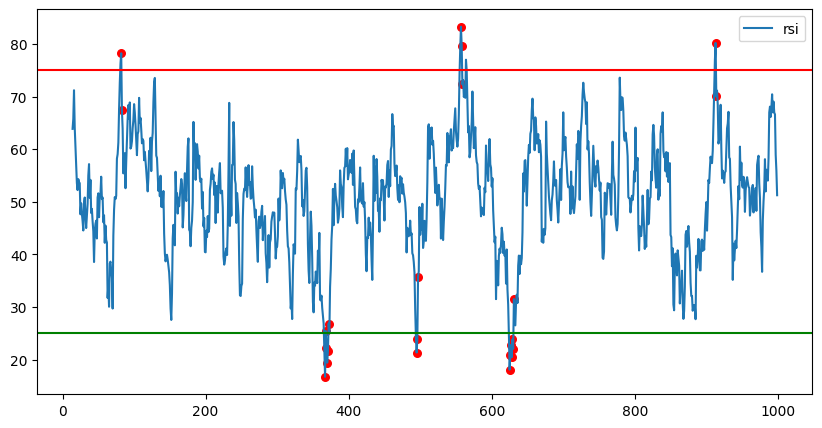

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from signals.find_signal import SignalFactory

pd.set_option('display.max_rows', 500)

high_bound = 75
low_bound = 25

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'])
ax.axhline(y=low_bound, color='g', linestyle='-')
ax.axhline(y=high_bound, color='r', linestyle='-')
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', configs)

for index, row in df.iterrows():
    if index > 2:
        if rsi_sig.higher_bound(df['rsi'], index, high_bound) or rsi_sig.lower_bound(df['rsi'], index, low_bound):
            scatter_rsi_points.append((index, df.loc[index, 'rsi']))

for point in scatter_rsi_points:
    ax.scatter(point[0], point[1], s=30, color='red')

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

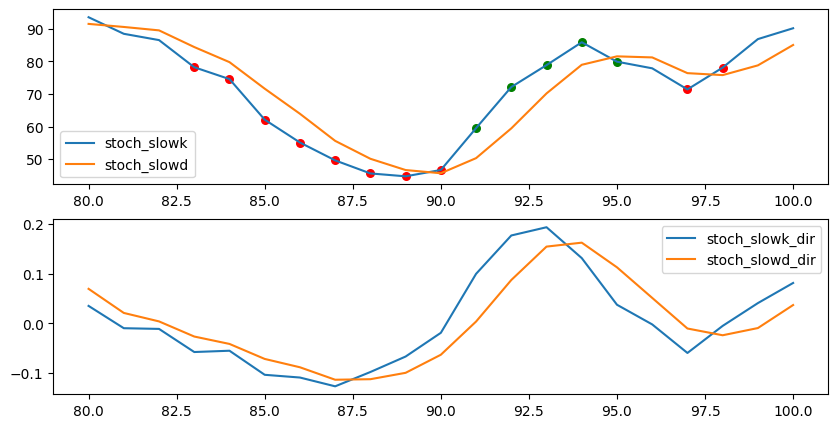

In [3]:
# subplots for STOCH
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[80:100, 'stoch_slowk'])
ax1.plot(df.loc[80:100, 'stoch_slowd'])
ax2.plot(df.loc[80:100, 'stoch_slowk_dir'])
ax2.plot(df.loc[80:100, 'stoch_slowd_dir'])
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 80 < index < 100:
        if (stoch_sig.up_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.up_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_up.append((index, df.loc[index, 'stoch_slowk']))
        if (stoch_sig.down_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.down_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_down.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_up:
    ax1.scatter(point[0], point[1], s=30, color='green')

for point in scatter_stoch_points_down:
    ax1.scatter(point[0], point[1], s=30, color='red')

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

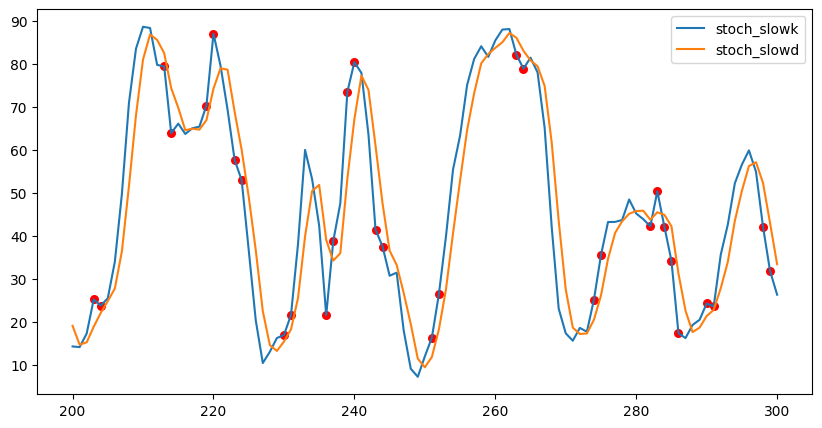

In [4]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ax.plot(df.loc[200:300, 'stoch_slowk'])
ax.plot(df.loc[200:300, 'stoch_slowd'])
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 200 < index < 300:
        if stoch_sig.crossed_lines(df['stoch_diff'], index, True) or \
           stoch_sig.crossed_lines(df['stoch_diff'], index, False):
            scatter_stoch_points.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points:
    ax.scatter(point[0], point[1], s=30, color='red')

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

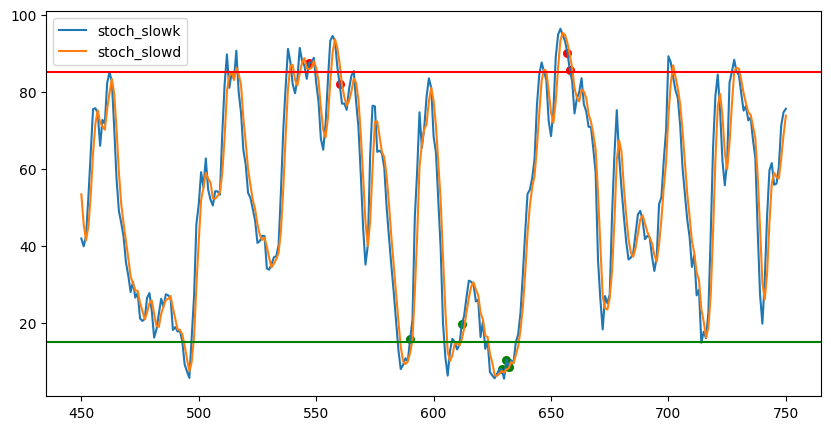

In [5]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
high_bound = 85
low_bound = 15
ax.plot(df.loc[450:750, 'stoch_slowk'])
ax.plot(df.loc[450:750, 'stoch_slowd'])
ax.axhline(y=low_bound, color='g', linestyle='-')
ax.axhline(y=high_bound, color='r', linestyle='-')
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 450 < index < 750:
        fs = stoch_sig.find_signal(df, index)
        if fs[0]:
            if fs[1] == 'buy':
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            else:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')

# Test check_levels method for SUP_RES indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

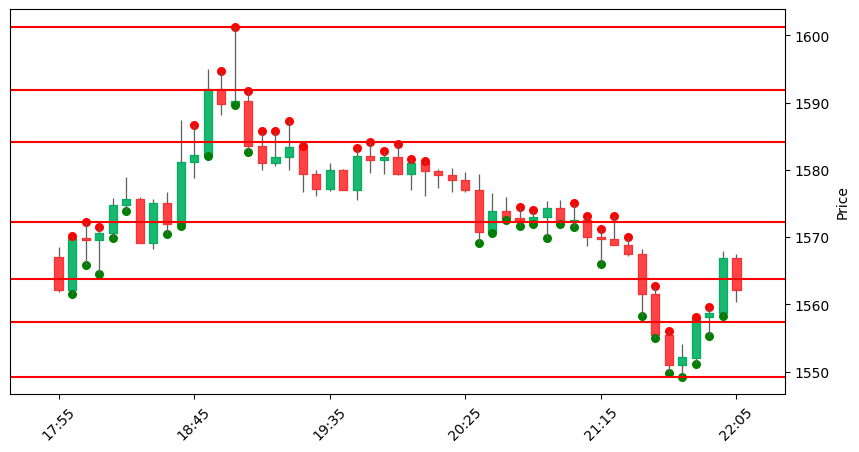

In [18]:
low_bound = 450
high_bound = 500

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
levels = dfs['ETHUSDT']['5m']['levels']
level_proximity = np.mean(df['high'] - df['low']) * sup_res_sig.proximity_multiplier

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax, warn_too_much_data=10000, style='yahoo')

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()

# get signal points
for index, row in df.iterrows():
    for buy in [False, True]:
        if low_bound < index < high_bound:
            fs = sup_res_sig.check_levels(df, index, levels, level_proximity, buy)
            if fs:
                if buy:
                    scatter_candle_points_buy.append((index, df.loc[index, 'low']))
                else:
                    scatter_candle_points_sell.append((index, df.loc[index, 'high']))

for point in scatter_candle_points_buy:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='green')
    
for point in scatter_candle_points_sell:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='red')
    
# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax.axhline(y=level[0], color='r', linestyle='-')

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI))

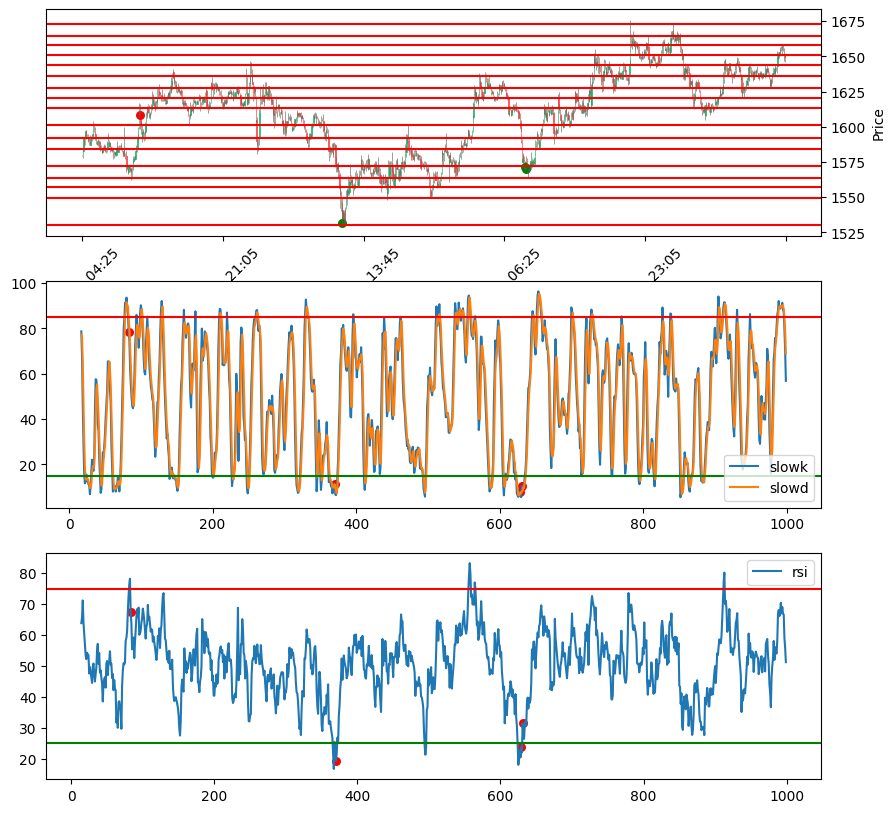

In [6]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
df = dfs['ETHUSDT']['5m']['data']
levels = dfs['ETHUSDT']['5m']['levels']
points = fs.find_signal(df, levels)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[0], df.loc[point[0], 'low']))
    else:
        scatter_candle_points_sell.append((point[0], df.loc[point[0], 'high']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

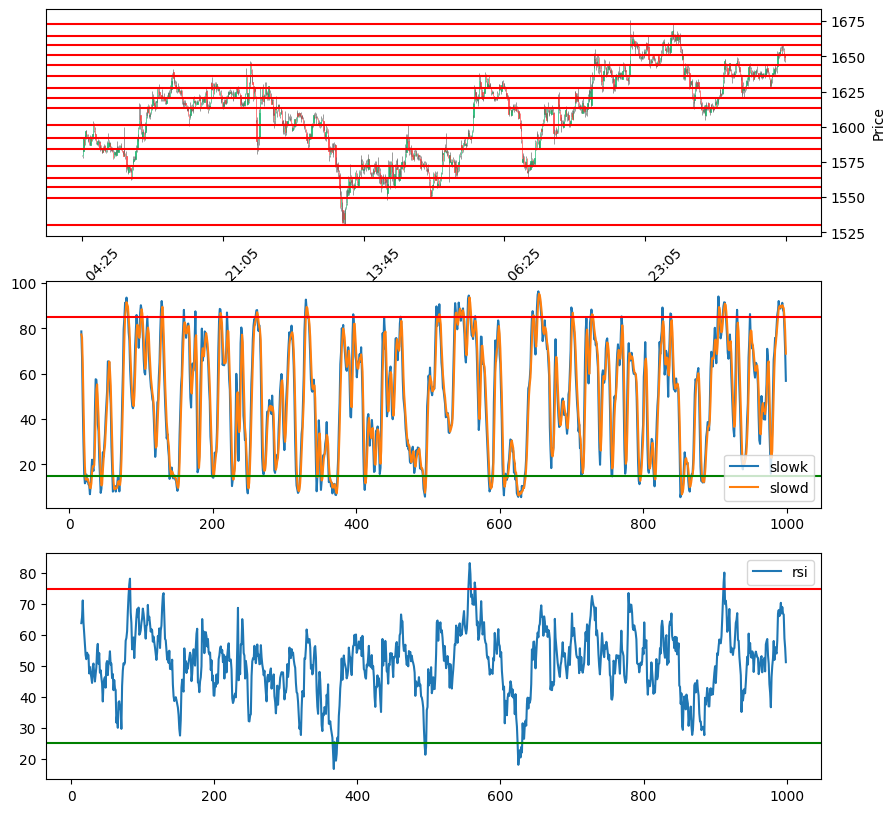

In [8]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['ETHUSDT']['5m']['data']
levels = dfs['ETHUSDT']['5m']['levels']
points = fs.find_signal(df, levels)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[0], df.loc[point[0], 'low']))
    else:
        scatter_candle_points_sell.append((point[0], df.loc[point[0], 'high']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')

# Test find_signal method of FindSignal class 

Parameters: (ETHUSDT, 5m, pattern: (STOCH, RSI))

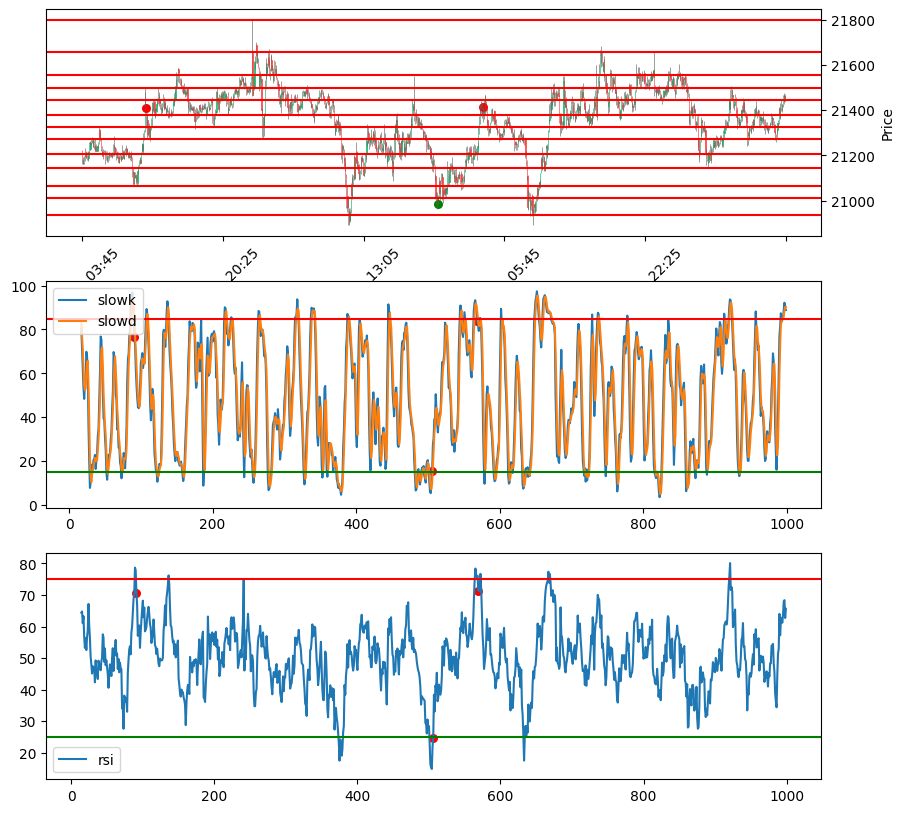

In [7]:
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
df = dfs['BTCUSDT']['5m']['data']
levels = dfs['BTCUSDT']['5m']['levels']
points = fs.find_signal(df, levels)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-')
ax2.axhline(y=85, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-')
ax3.axhline(y=75, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[0], df.loc[point[0], 'low']))
    else:
        scatter_candle_points_sell.append((point[0], df.loc[point[0], 'high']))
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')

## Plot STOCH values

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import mplfinance as mpf

# low_bound = 500
# high_bound = 600

# pd.set_option('display.max_rows', 500)

# levels = dfs['ETHUSDT']['5m']['levels']

# # subplots for STOCH and RSI
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

# # plot candles
# ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
# ohlc = ohlc.set_index('time')
# mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# # plot STOCH
# ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'])
# ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'])
# # show boundaries
# ax2.axhline(y=15, color='g', linestyle='-')
# ax2.axhline(y=85, color='r', linestyle='-')
# leg = ax2.legend(['slowk', 'slowd'])

# # plot RSI
# ax3.plot(df.loc[low_bound:high_bound, 'rsi'])
# ax3.axhline(y=25, color='g', linestyle='-')
# ax3.axhline(y=75, color='r', linestyle='-')
# leg = ax3.legend(['rsi'])

# # find signal points
# for index, row in df.iterrows():
#     if sup_res_sig.check_levels(df, index, levels, level_proximity, True):
#         scatter_sup_res_points_buy.append((index, df.loc[index, 'low']))
#     if sup_res_sig.check_levels(df, index, levels, level_proximity, False):
#         scatter_sup_res_points_sell.append((index, df.loc[index, 'high']))

# # plot signal points
# scatter_candle_points = list()
# scatter_stoch_points = list()
# scatter_rsi_points = list()

# for point in points:
#     scatter_candle_points.append((point[0], df.loc[point[0], 'close']))
#     scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
#     scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))

# for point in scatter_candle_points:
#     if low_bound < point[0] < high_bound:
#         ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')

# for point in scatter_stoch_points:
#     if low_bound < point[0] < high_bound:
#         ax2.scatter(point[0], point[1], s=30, color='red')

# for point in scatter_rsi_points:
#     if low_bound < point[0] < high_bound:
#         ax3.scatter(point[0], point[1], s=30, color='red')

# # plot levels
# for level in levels:
#     # show bounders
#     if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
#         ax1.axhline(y=level[0], color='r', linestyle='-')
# #         ax1.text(150, level[0], level[0], ha='left', va='center')